In [1]:
import torch
import torchvision.datasets as dsets
from torchvision import transforms
import random
import matplotlib.pyplot as plt


# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set seed for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

torch.__version__, device

('1.7.0+cu101', 'cuda')

## Batch Normalization
- Gradient Vanishing/Exploding 을 방지하기 위한 방법들 <br>
  1) Change activation function <br>
  2) Change Initialization method <br>
  3) Small learning rate (only for exploding) <br>
  4) Batch Normalization <br> <br>
- 특히 Batch Normalization 은 전반적인 학습을 안정적(stable)으로 만들어 주는 우수한 방법
  - cf. Internal Covariate Shift

In [2]:
# set parameters
batch_size = 32
n_epochs = 10
learning_rate = 0.01

# prepare data
mnist_train = dsets.MNIST(root='mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_valid = dsets.MNIST(root='mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader  = torch.utils.data.DataLoader(dataset=mnist_valid, batch_size=batch_size, shuffle=True, drop_last=True)

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# build model 1 - model with Batchnorm
linear1 = torch.nn.Linear(28*28, 32, bias=True).to(device)
linear2 = torch.nn.Linear(32, 32, bias=True).to(device)
linear3 = torch.nn.Linear(32, 10, bias=True).to(device)
relu = torch.nn.ReLU()
batchnorm1 = torch.nn.BatchNorm1d(32).to(device)
batchnorm2 = torch.nn.BatchNorm1d(32).to(device)

bn_model = torch.nn.Sequential(
    linear1, batchnorm1, relu,
    linear2, batchnorm2, relu,
    linear3
)
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)


# build model 2 - model without Batchnorm
nn_linear1 = torch.nn.Linear(28*28, 32, bias=True).to(device)
nn_linear2 = torch.nn.Linear(32, 32, bias=True).to(device)
nn_linear3 = torch.nn.Linear(32, 10, bias=True).to(device)

nn_model = torch.nn.Sequential(
    linear1, relu,
    linear2, relu,
    linear3
)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)


# # initialize weights
# for layer in [linear1, linear2, linear3, nn_linear1, nn_linear2, nn_linear3]:
#   torch.nn.init.xavier_normal_(layer.weight)  # Xavier Initialization

# Define Loss function
criterion = torch.nn.CrossEntropyLoss().to(device)  # Softmax is internally computed

In [4]:
%time

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
valid_total_batch = len(valid_loader)

for epoch in range(n_epochs):
  bn_model.train()
  nn_model.train()
  # train models
  for x_train, y_train in train_loader:
    ## reshape input image into [batch_size by 784]
    ## label is not one-hot encoded
    x_train = x_train.view(-1, 28 * 28).to(device)
    y_train = y_train.to(device)

    ## train model1 (with Batchnorm)
    bn_prediction = bn_model(x_train)
    bn_loss = criterion(bn_prediction, y_train)
    bn_optimizer.zero_grad()
    bn_loss.backward()
    bn_optimizer.step()

    ## train model2 (without Batchnorm)
    nn_prediction = nn_model(x_train)
    nn_loss = criterion(nn_prediction, y_train)
    nn_optimizer.zero_grad()
    nn_loss.backward()
    nn_optimizer.step()

  # calculate loss & accuracy
  with torch.no_grad():
    bn_model.eval()
    nn_model.eval()

    for loader, total_batch, status in zip([train_loader, valid_loader], [train_total_batch, valid_total_batch], ['train', 'val']):
      ## calculate loss & accuracy
      bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
      for i, (x_data, y_data) in enumerate(loader):
        x_data = x_data.view(-1, 28 * 28).to(device)
        y_data = y_data.to(device)

        bn_prediction = bn_model(x_data)
        bn_correct_prediction = torch.argmax(bn_prediction, 1) == y_data
        bn_loss += criterion(bn_prediction, y_data) / total_batch
        bn_acc += bn_correct_prediction.float().mean() / total_batch

        nn_prediction = nn_model(x_data)
        nn_correct_prediction = torch.argmax(nn_prediction, 1) == y_data
        nn_loss += criterion(nn_prediction, y_data) / total_batch
        nn_acc += nn_correct_prediction.float().mean() / total_batch
      
      ## Save loss & accuracy
      if status == 'train':
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(f'[Epoch {epoch+1:4d}-TRAIN] Batchnorm Loss(Acc): bn_loss:{bn_loss:10.5f}(bn_acc:{bn_acc:6.2f}) vs No Batchnorm Loss(Acc): nn_loss:{nn_loss:10.5f}(nn_acc:{nn_acc:6.2f})')
      else:  # status == 'val'
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(f'[Epoch {epoch+1:4d}-VALID] Batchnorm Loss(Acc): bn_loss:{bn_loss:10.5f}(bn_acc:{bn_acc:6.2f}) vs No Batchnorm Loss(Acc): nn_loss:{nn_loss:10.5f}(nn_acc:{nn_acc:6.2f})\n')
    
print('Learning finished')

    
    # ## calculate train loss & accuracy
    # bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
    # for i, (x_train, y_train) in enumerate(train_loader):
    #     x_train = x_train.view(-1, 28 * 28).to(device)
    #     y_train = y_train.to(device)

    #     bn_prediction = bn_model(x_train)
    #     bn_correct_prediction = torch.argmax(bn_prediction, 1) == y_train
    #     bn_loss += criterion(bn_prediction, y_train) / train_total_batch
    #     bn_acc += bn_correct_prediction.float().mean() / train_total_batch

    #     nn_prediction = nn_model(x_train)
    #     nn_correct_prediction = torch.argmax(nn_prediction, 1) == y_train
    #     nn_loss += criterion(nn_prediction, y_train) / train_total_batch
    #     nn_acc += nn_correct_prediction.float().mean() / train_total_batch

    # ## Save train loss & accuracy
    # train_losses.append([bn_loss, nn_loss])
    # train_accs.append([bn_acc, nn_acc])
    # print(f'[Epoch {epoch+1:4d}-TRAIN] Batchnorm Loss(Acc): bn_loss:{bn_loss:10.5f}(bn_acc:{bn_acc:6.2f}) vs No Batchnorm Loss(Acc): nn_loss:{nn_loss:10.5f}(nn_acc:{nn_acc:6.2f})')


    # ## calculate validation loss & accuracy
    # bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
    # for i, (x_val, y_val) in enumerate(valid_loader):
    #     x_val = x_val.view(-1, 28 * 28).to(device)
    #     y_val = y_val.to(device)

    #     bn_prediction = bn_model(x_val)
    #     bn_correct_prediction = torch.argmax(bn_prediction, 1) == y_val
    #     bn_loss += criterion(bn_prediction, y_val) / valid_total_batch
    #     bn_acc += bn_correct_prediction.float().mean() / valid_total_batch

    #     nn_prediction = nn_model(x_val)
    #     nn_correct_prediction = torch.argmax(nn_prediction, 1) == y_val
    #     nn_loss += criterion(nn_prediction, y_val) / valid_total_batch
    #     nn_acc += nn_correct_prediction.float().mean() / valid_total_batch

    # ## Save validation loss & accuracy
    # valid_losses.append([bn_loss, nn_loss])
    # valid_accs.append([bn_acc, nn_acc])
    # print(f'[Epoch {epoch+1:4d}-VALID] Batchnorm Loss(Acc): bn_loss:{bn_loss:10.5f}(bn_acc:{bn_acc:6.2f}) vs No Batchnorm Loss(Acc): nn_loss:{nn_loss:10.5f}(nn_acc:{nn_acc:6.2f})\n')

print('Learning finished')

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs
[Epoch    1-TRAIN] Batchnorm Loss(Acc): bn_loss:   0.15930(bn_acc:  0.95) vs No Batchnorm Loss(Acc): nn_loss:   0.23681(nn_acc:  0.94)
[Epoch    1-VALID] Batchnorm Loss(Acc): bn_loss:   0.17097(bn_acc:  0.95) vs No Batchnorm Loss(Acc): nn_loss:   0.25066(nn_acc:  0.93)

[Epoch    2-TRAIN] Batchnorm Loss(Acc): bn_loss:   0.10917(bn_acc:  0.97) vs No Batchnorm Loss(Acc): nn_loss:   0.21200(nn_acc:  0.95)
[Epoch    2-VALID] Batchnorm Loss(Acc): bn_loss:   0.12062(bn_acc:  0.96) vs No Batchnorm Loss(Acc): nn_loss:   0.24412(nn_acc:  0.94)

[Epoch    3-TRAIN] Batchnorm Loss(Acc): bn_loss:   0.09826(bn_acc:  0.97) vs No Batchnorm Loss(Acc): nn_loss:   0.20330(nn_acc:  0.95)
[Epoch    3-VALID] Batchnorm Loss(Acc): bn_loss:   0.11802(bn_acc:  0.96) vs No Batchnorm Loss(Acc): nn_loss:   0.23865(nn_acc:  0.94)

[Epoch    4-TRAIN] Batchnorm Loss(Acc): bn_loss:   0.08922(bn_acc:  0.97) vs No Batchnorm Loss(Acc): nn_loss:   0.2

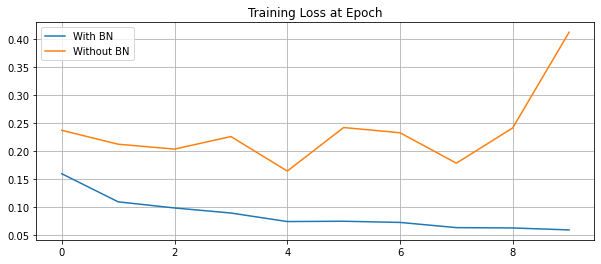

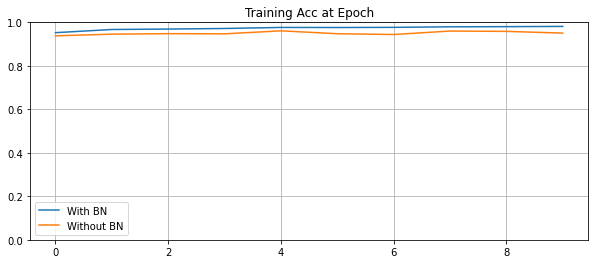

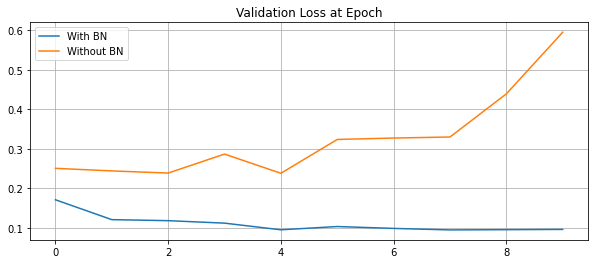

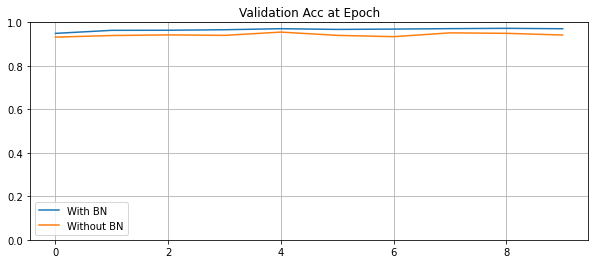

In [5]:
# visualize learning curve
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(10, 4))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()


plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')

Label: 8
Prediction (bn) :  3
Prediction (nn) :  8


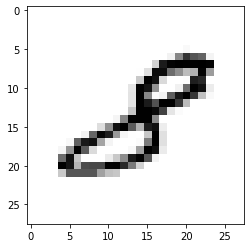




Label: 5
Prediction (bn) :  5
Prediction (nn) :  5


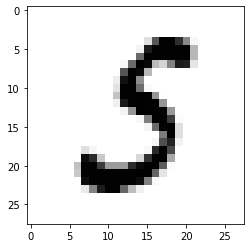




Label: 7
Prediction (bn) :  7
Prediction (nn) :  7


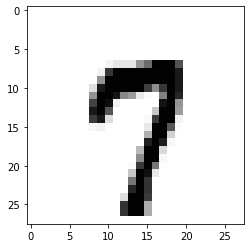




Label: 9
Prediction (bn) :  9
Prediction (nn) :  9


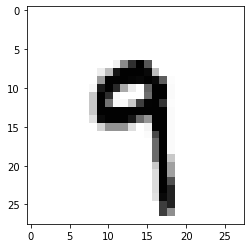




Label: 3
Prediction (bn) :  3
Prediction (nn) :  3


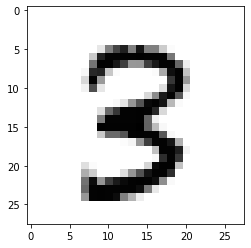

In [6]:
# visualization
for i in range(5):
  r = random.randint(0, len(mnist_valid)-1) # 0~9999까지 랜덤한 정수
  X_single_data = mnist_valid.data[r].view(-1, 28*28).float().to(device)
  Y_single_data = mnist_valid.targets[r].to(device)

  bn_single_prediction = bn_model(X_single_data)
  nn_single_prediction = nn_model(X_single_data)
  print('Label:', Y_single_data.item())
  print('Prediction (bn) : ', torch.argmax(bn_single_prediction, 1).item())
  print('Prediction (nn) : ', torch.argmax(nn_single_prediction, 1).item())

  plt.imshow(mnist_valid.data[r].view(28,28), cmap='Greys', interpolation='nearest')
  plt.show()

  print('\n\n')